In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE
from pandas.tools.plotting import andrews_curves
import os
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import radviz
import scipy

In [86]:
#Modelling
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
#import lightgbm as lgb
import warnings

In [87]:
os.chdir('/home/py/data/AUTO/')

In [88]:
df = pd.read_csv('auto_ex_zero.csv')

In [89]:
df.shape

(998, 12)

In [90]:
del df['Company.Name']
del df['PSALES']
del df['EVEBITDA']
del df['P.B']

In [91]:
df.head(5)

,YEAR,ROE,ROC,NPM,DIV,DEP,Beta,P.E
0,1991,46.00,24.52,20.09,10.34,15.3,0.28,15.36
1,1985,21.10,14.99,6.22,8.48,170.0,0.88,9.42
2,1985,32.04,17.88,6.74,4.23,244.5,0.94,11.90
3,1985,21.00,11.57,4.83,8.49,345.6,0.96,4.07
4,1985,34.97,25.03,9.68,14.83,429.5,1.13,8.42


# Feature Engineering

In [92]:
df["YEAR"] = df["YEAR"].astype("category")

In [93]:
# put ages in categories and add as columns to DataFrame
age_bins = [0, 1960, 1970, 1980, 1990,2000,2017]
age_labels = ["1", "2", "3", "4","5","6"]
df['YEAR'] = pd.cut(df['YEAR'], age_bins, labels=age_labels,right=True, include_lowest=True)

In [94]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

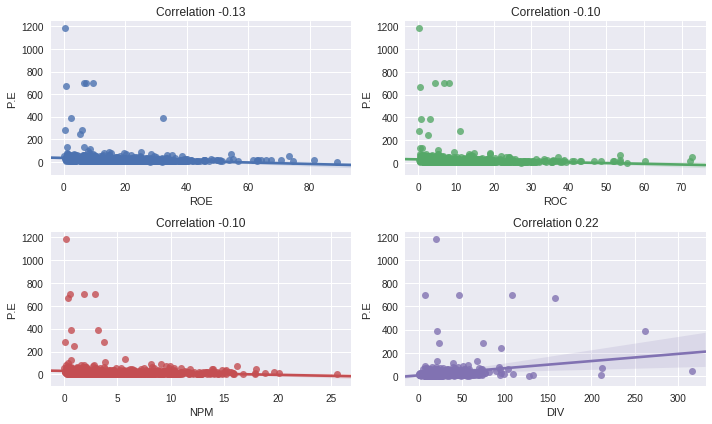

In [96]:
feats = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']

multiplot(data = df,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = 'P.E', colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



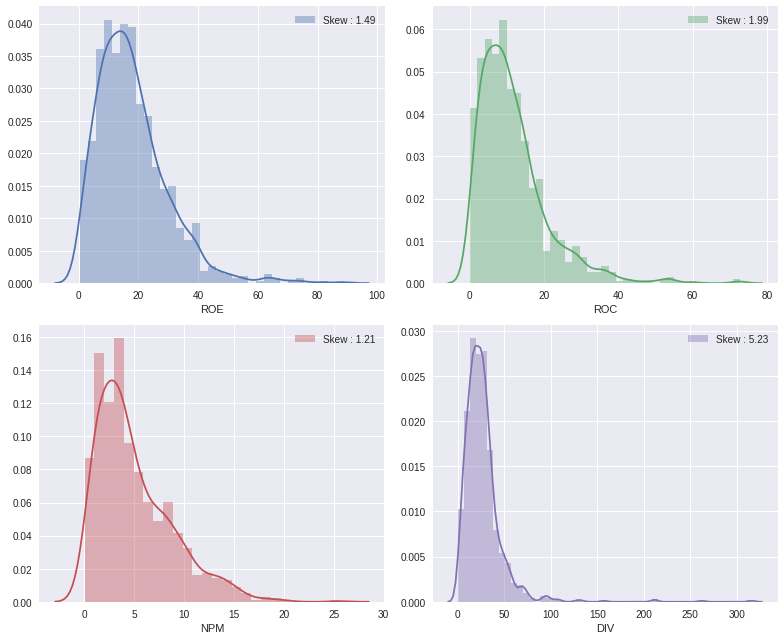

In [97]:
skewed_features = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



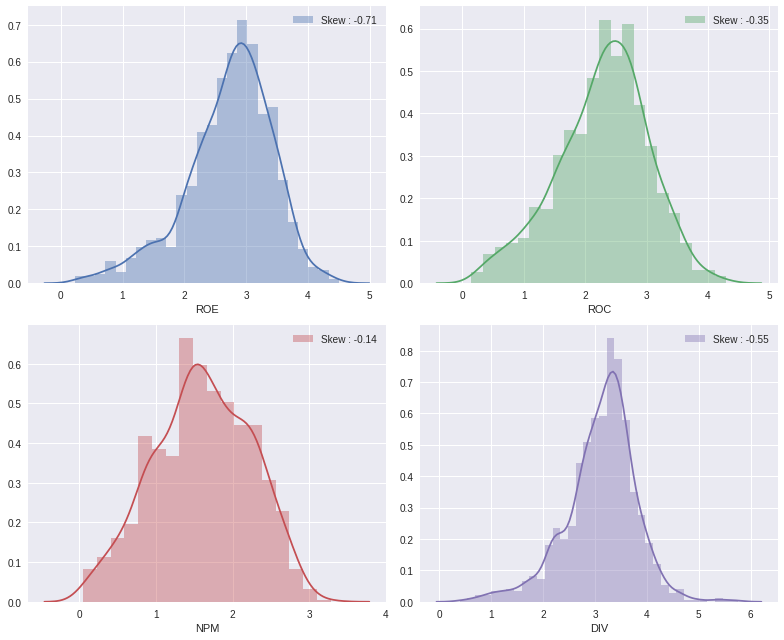

In [98]:
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



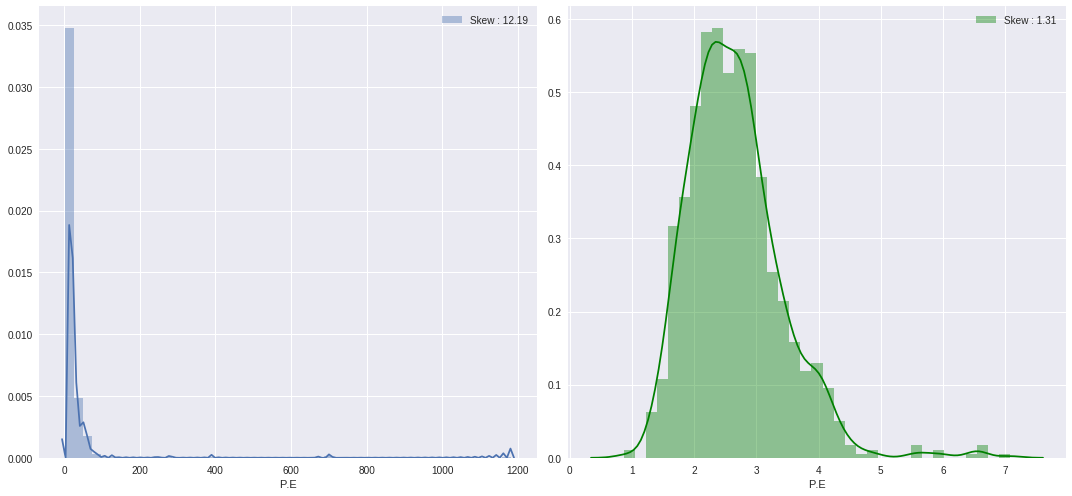

In [100]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(df['P.E'],ax = axes[0])
sns.distplot(np.log1p(df['P.E']),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(df['P.E'].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(df['P.E']).skew())])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [101]:
df.columns

Index(['YEAR', 'ROE', 'ROC', 'NPM', 'DIV', 'DEP', 'Beta', 'P.E'], dtype='object')

In [102]:
t = df.iloc[:,1:7]

In [104]:
z= df.filter(['YEAR','P.E'], axis=1)

In [106]:
list_ib = t.columns.values

for i in list_ib:
    for j in list_ib:
        if i == j:
            break
        else:
            new = t[i] * t[j]
            t['new_' + str(i) + '_' + str(j)] = new # Add new column which is the result of multiplying columns i and j together

In [107]:
df = pd.concat([t, z], axis = 1)

In [108]:
# Convert year to category
df['Age_1'] = df['YEAR'].map(lambda s: 1 if s == '1' else 0)
df['Age_2'] = df['YEAR'].map(lambda s: 1 if s == '2' else 0)
df['Age_3'] = df['YEAR'].map(lambda s: 1 if s == '3' else 0)
df['Age_4'] = df['YEAR'].map(lambda s: 1 if s == '4' else 0)
df['Age_5'] = df['YEAR'].map(lambda s: 1 if s == '5' else 0)
df['Age_6'] = df['YEAR'].map(lambda s: 1 if s == '6'  else 0)

In [109]:
df.head(5)

,ROE,ROC,NPM,DIV,DEP,Beta,new_ROC_ROE,new_NPM_ROE,new_NPM_ROC,new_DIV_ROE,...,new_Beta_DIV,new_Beta_DEP,YEAR,P.E,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
0,3.850148,3.239462,3.048799,2.428336,2.791165,0.246860,12.472409,11.738326,9.876470,9.349453,...,0.599459,0.689027,5,15.36,0,0,0,0,1,0
1,3.095578,2.771964,1.976855,2.249184,5.141664,0.631272,8.580828,6.119508,5.479770,6.962525,...,1.419847,3.245787,4,9.42,0,0,0,1,0,0
2,3.497719,2.938103,2.046402,1.654411,5.503297,0.662688,10.276659,7.157738,6.012539,5.786666,...,1.096358,3.646969,4,11.90,0,0,0,1,0,0
3,3.091042,2.531313,1.763017,2.250239,5.848171,0.672944,7.824396,5.449560,4.462748,6.955583,...,1.514286,3.935495,4,4.07,0,0,0,1,0,0
4,3.582685,3.259250,2.368373,2.761907,6.064947,0.756122,11.676866,8.485134,7.719118,9.895043,...,2.088338,4.585840,4,8.42,0,0,0,1,0,0


# Explanotary Data Analysis

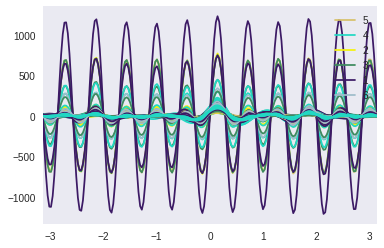

In [110]:
andrews_curves(df, 'YEAR')
plt.show()

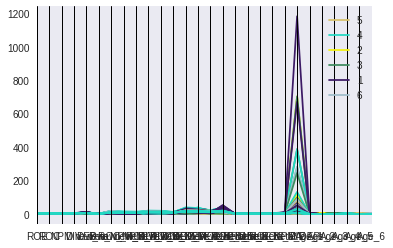

In [111]:
parallel_coordinates(df, 'YEAR')

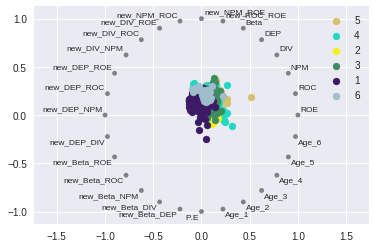

In [112]:
radviz(df, 'YEAR')

In [113]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
)

In [114]:
tsne_results = tsne.fit_transform(df.iloc[:, 1:], df.iloc[:, 0:])

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 998 / 998
[t-SNE] Mean sigma: 3.848831
[t-SNE] Iteration 25: error = 1.3842039, gradient norm = 0.0218462
[t-SNE] Iteration 50: error = 1.2457843, gradient norm = 0.0178196
[t-SNE] Iteration 75: error = 1.0878280, gradient norm = 0.0108729
[t-SNE] Iteration 100: error = 1.0159951, gradient norm = 0.0129986
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.015995
[t-SNE] Iteration 125: error = 1.0246124, gradient norm = 0.0081526
[t-SNE] Iteration 150: error = 1.0248525, gradient norm = 0.0125541
[t-SNE] Iteration 175: error = 0.9145283, gradient norm = 0.0114972
[t-SNE] Iteration 200: error = 0.8507431, gradient norm = 0.0111374
[t-SNE] Iteration 225: error = 0.9103467, gradient norm = 0.0111701
[t-SNE] Iteration 250: error = 0.7456374, gradient norm = 0.0066185
[t-SNE] Iteration 275: error = 0.5674084, gradient norm = 0.0013412
[t-

In [116]:
trace1 = go.Scatter3d(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    z=tsne_results[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df['P.E'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'YEAR'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='Data')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [117]:
df.drop(labels=["YEAR"],axis = 1,inplace=True)

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



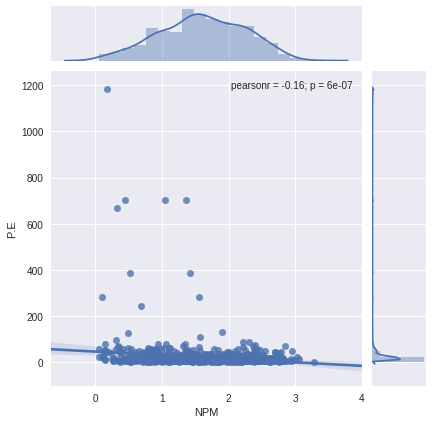

In [118]:
g = sns.jointplot(x = df['NPM'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



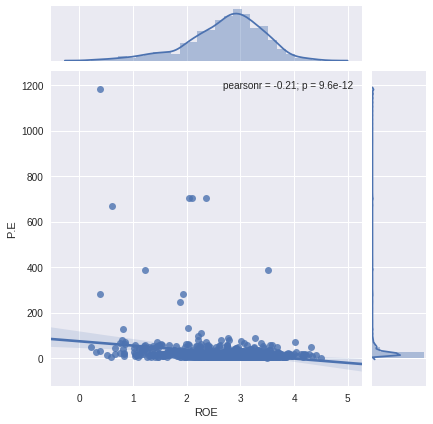

In [119]:
g = sns.jointplot(x = df['ROE'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



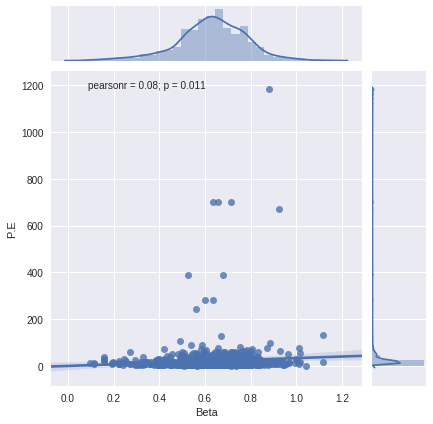

In [120]:
g = sns.jointplot(x = df['Beta'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



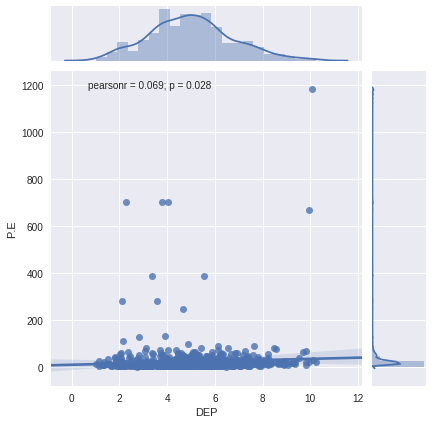

In [121]:
g = sns.jointplot(x = df['DEP'], y = df['P.E'],kind="reg")

/home/py/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



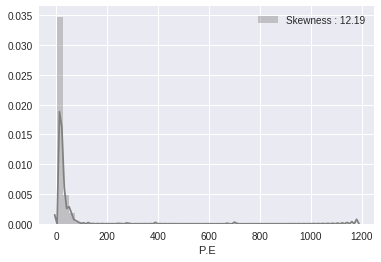

In [122]:
g = sns.distplot(df['P.E'],color="gray")
g = g.legend(['Skewness : {:.2f}'.format(df['P.E'].skew())],loc='best')

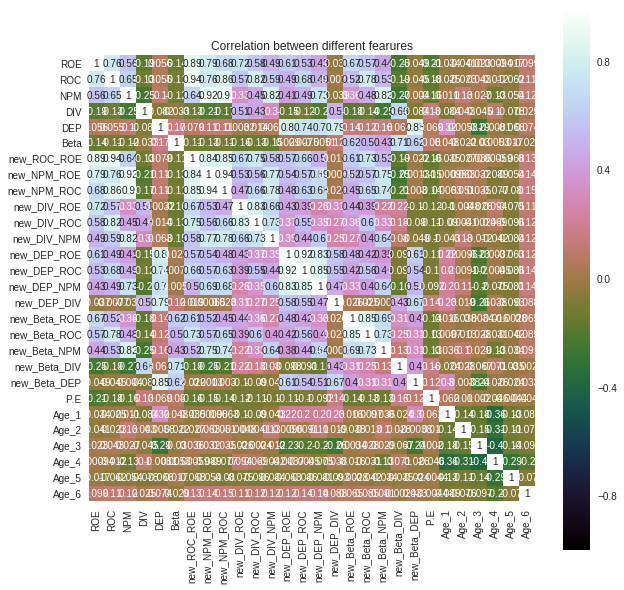

In [123]:
correlation = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

plt.title('Correlation between different fearures')

# Transformation

In [125]:
df['P.E'] = np.log1p(df['P.E'])
Y = df['P.E']
df = df.drop(labels="P.E",axis = 1)

In [126]:
features = df.columns

In [127]:
# Normalize data 
#N = Normalizer()
N = RobustScaler()

N.fit(df)

df = N.transform(df)

In [128]:
train_len = len(df)

In [129]:
## Separate train dataset 
X_train = df[:train_len]

In [130]:
###### Train classifiers
Y_train = Y[:train_len]

In [131]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

# 6.1.1 Cross validate models

In [132]:
# Regression linear models (Lasso, Ridge, Elasticnet)
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [133]:
RMSE(lassocv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



0.6984831399783149

In [134]:
RMSE(ridge, X_train, Y_train)

0.71314585903785344

In [135]:
RMSE(lassolarscv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.600e-03, previous alpha=1.036e-04, with an active set of 15 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.600e-03, previous alpha=1.036e-04, with an active set of 15 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 33 iterations, alpha=2.587e-03, previous alpha=2.121e-04, with an active set of 18 regressors.

/home/py/anaconda3/lib/python3.6/s

0.70582423739833888

In [136]:
RMSE(elasticnetcv, X_train, Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w

0.69811246717083486

In [137]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 34 iterations, alpha=5.619e-03, previous alpha=4.315e-05, with an active set of 23 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=3.278e-04, previous alpha=9.166e-05, with an active set of 19 regressors.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:334: Conve

ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

# Features coefficients

In [138]:
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("LassoLarsCV regression has conserved %d features over %d"%(len(features[lassolarscv.coef_!=0]) ,X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 11 features over 27
Ridge regression has conserved 27 features over 27
LassoLarsCV regression has conserved 12 features over 27
ElasticNetCV regression has conserved 14 features over 27


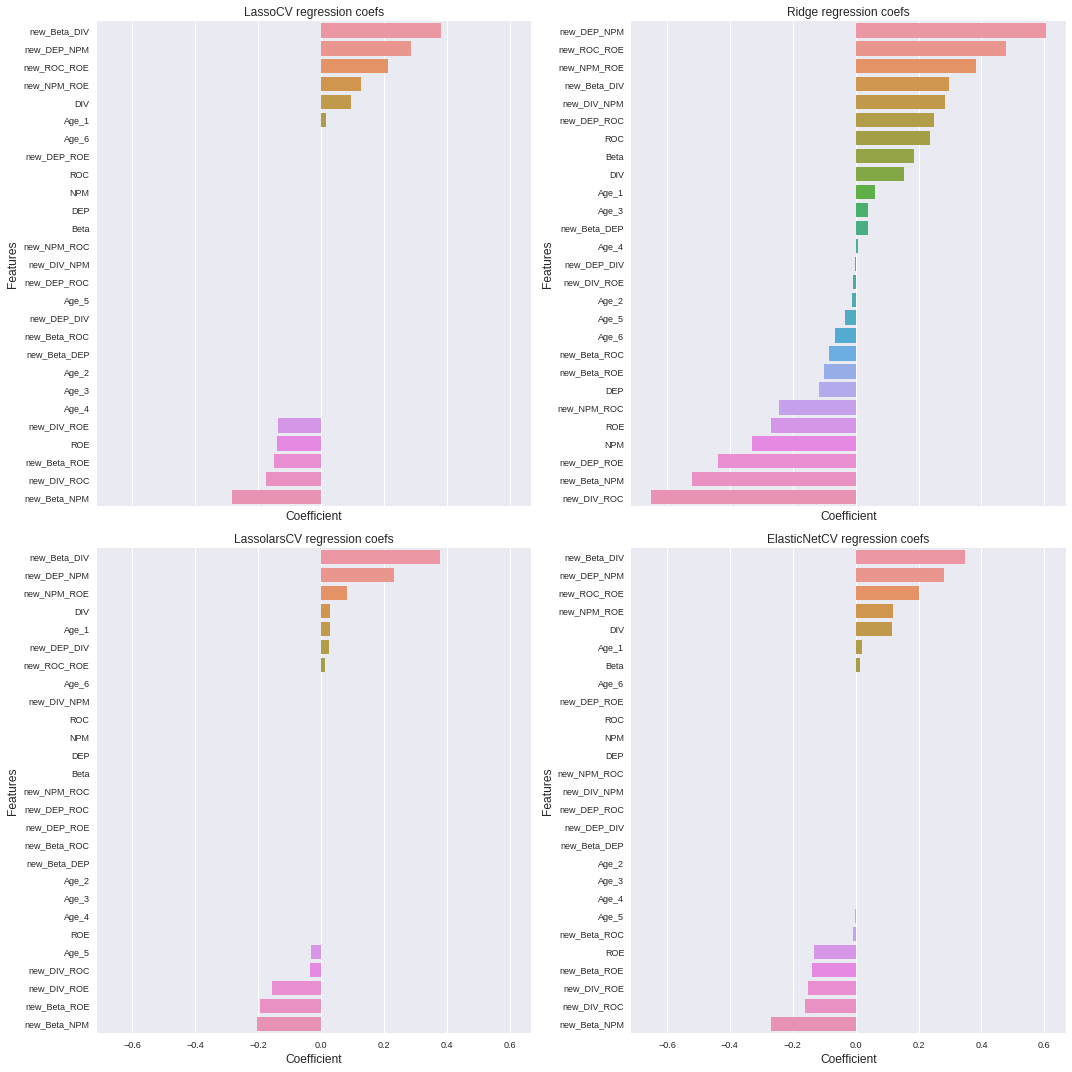

In [139]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarscv),("ElasticNetCV",elasticnetcv)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
plt.tight_layout()
plt.show()
plt.gcf().clear()

In [140]:
Y_pred_lassocv = np.expm1(lassocv.predict(X_train))
Y_pred_lassolarscv = np.expm1(lassolarscv.predict(X_train))
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(X_train))

# Tree based modeling

In [141]:
# XGBoost

#model_xgb = xgb.XGBRegressor(n_estimators=3000, max_depth=2, learning_rate=0.1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

RMSE(model_xgb,X_train,Y_train)

0.75352779846062423

In [142]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = np.expm1(model_xgb.predict(X_train))

In [143]:
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
RMSE(GBoost,X_train,Y_train)

0.74591845361578002

In [144]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = np.expm1(GBoost.predict(X_train))

In [256]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

RMSE(LightGB,X_train,Y_train)

0.51566382244804887

In [257]:
LightGB.fit(X_train,Y_train)
Y_pred_LightGB = np.expm1(LightGB.predict(X_train))

# Features importance

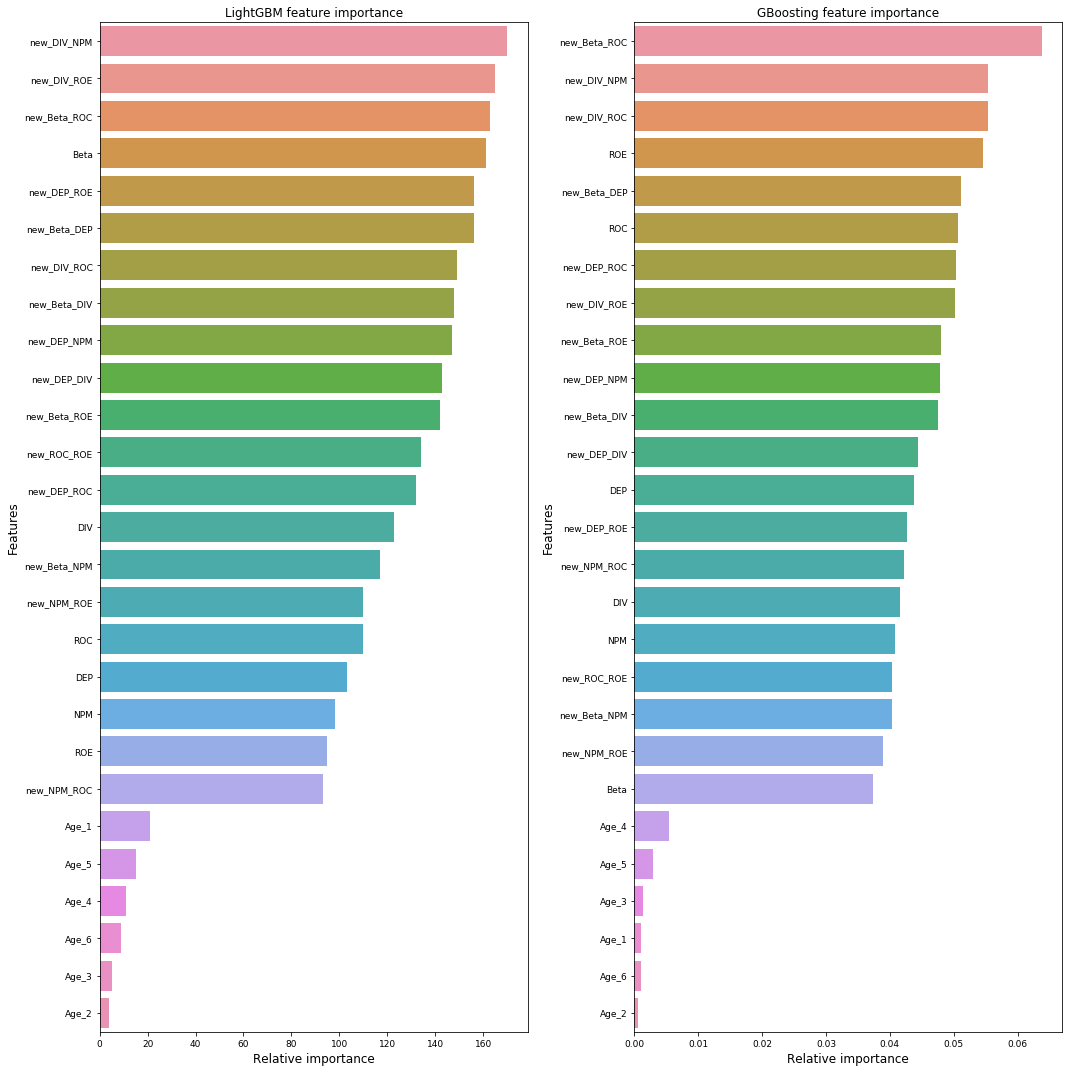

In [258]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_regressors = [("LightGBM",LightGB),("GBoosting",GBoost)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[nregressors])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressors += 1

plt.tight_layout()
plt.show()
plt.gcf().clear()

# Learning Rate

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/home/py/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data w

IndexError: list index out of range

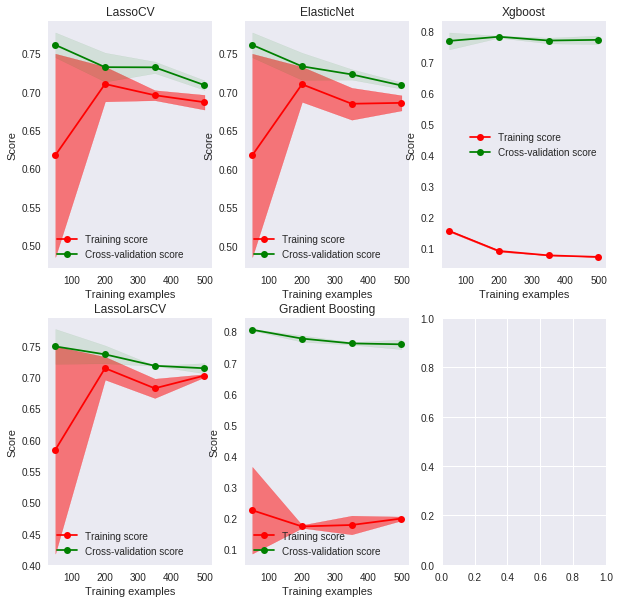

In [145]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 4)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.5,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost,model_xgb]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting","Xgboost"]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=2 ,n_jobs=4)